<a href="https://colab.research.google.com/github/cleopatra27/predict_rain_in_australia/blob/main/Rain_in_Australia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
## Introduction
# Using the Abalone Data Set, build a system to predict the age of an abalone from physical 
# features.  Try both a multi-class classifier and a regressor.  For the regressor, you decide what a 
# correct output is (within x from truth).   The description of the data is here.  The dataset is here.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# import data
data = pd.read_csv('weatherAUS.csv', sep=',')

In [34]:
# view data
data.head().T

,0,1,2,3,4
Date,2008-12-01,2008-12-02,2008-12-03,2008-12-04,2008-12-05
Location,Albury,Albury,Albury,Albury,Albury
MinTemp,13.4,7.4,12.9,9.2,17.5
MaxTemp,22.9,25.1,25.7,28,32.3
Rainfall,0.6,0,0,0,1
Evaporation,NaN,NaN,NaN,NaN,NaN
Sunshine,NaN,NaN,NaN,NaN,NaN
WindGustDir,W,WNW,WSW,NE,W
WindGustSpeed,44,44,46,24,41
WindDir9am,W,NNW,W,SE,ENE


In [35]:
# Next we need to know the types.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [36]:
# i think its better we have our date in simplified formats as it caan contribute to our model.
data['Date']=pd.to_datetime(data['Date'],format='%Y-%m-%d')
data['year']=data['Date'].dt.year
data['month']=data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data=data.drop('Date',axis=1)

In [37]:
# Lets take a look out our categorical data and handle nulls
data_cat = data.select_dtypes(include=['object'])
# data_cat
data_cat.isnull().sum()

Location            0
WindGustDir     10326
WindDir9am      10566
WindDir3pm       4228
RainToday        3261
RainTomorrow     3267
dtype: int64

In [38]:
# with the exception of 'Location' other values have quite a number of nulls, one way we can handle this is to use the mode to populate the nulls.
for i in data_cat:
    data[i].fillna(data[i].mode()[0], inplace=True)
data.isnull().sum()

Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir          0
WindGustSpeed    10263
WindDir9am           0
WindDir3pm           0
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday            0
RISK_MM           3267
RainTomorrow         0
year                 0
month                0
Day                  0
dtype: int64

In [39]:
# Still on our categorical data, lets encode them to be able to pass it through any model
one_hot_var = list(data_cat)
for i in one_hot_var:
    hotted_var = pd.get_dummies(data[i], prefix=i, prefix_sep='_', drop_first=True) 
    data = data.join(hotted_var)
    data.drop(i, axis = 1, inplace = True)

In [40]:
# Next lets handle our numerical data
data_num = data.select_dtypes(include=['float64'])
data_num.isnull().sum()

MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RISK_MM           3267
dtype: int64

In [41]:
for i in data_num:
    data[i].fillna(data[i].mean(), inplace=True)
print(data.isnull().sum())

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
                   ..
WindDir3pm_W        0
WindDir3pm_WNW      0
WindDir3pm_WSW      0
RainToday_Yes       0
RainTomorrow_Yes    0
Length: 115, dtype: int64


In [42]:
# We no longer have nulls, next lets start looking for linearlity or correlation between values 
data.describe()
# First we can see some abnormal distance in our data

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM,year,month,Day,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,...,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,...,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.00000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.649940,1015.255889,4.447461,4.509930,16.990631,21.683390,2.360682,2012.769751,6.399615,15.712258,0.020899,0.020899,0.020899,0.020686,0.020899,0.020899,0.021951,0.020899,0.023622,0.020686,0.020686,0.020686,0.021951,0.020899,0.021951,0.010848,0.020899,0.021951,0.020686,0.020686,...,0.063028,0.064746,0.063358,0.060058,0.061646,0.139152,0.056730,0.062347,0.053870,0.052454,0.153472,0.052736,0.055885,0.054860,0.060147,0.059528,0.063846,0.062643,0.052159,0.057906,0.058153,0.050969,0.048288,0.054015,0.05847,0.061116,0.056806,0.045305,0.054104,0.059192,0.068239,0.103575,0.064616,0.056070,0.064306,0.069504,0.061006,0.065434,0.219167,0.219146
std,6.365750,7.088124,8.382488,3.161541,2.729486,13.118253,8.861059,8.716581,18.854765,20.471189,6.728467,6.663973,2.265604,2.092954,6.449221,6.850057,8.382221,2.537684,3.427262,8.794789,0.143047,0.143047,0.143047,0.142332,0.143047,0.143047,0.146524,0.143047,0.151868,0.142332,0.142332,0.142332,0.146524,0.143047,0.146524,0.103589,0.143047,0.146524,0.142332,0.142332,...,0.243013,0.246079,0.243606,0.237595,0.240512,0.346106,0.231327,0.241786,0.225763,0.222942,0.360443,0.223507,0.229700,0.227708,0.237760,0.236612,0.244479,0.242320,0.222348,0.233566,0.234034,0.219936,0.214375,0.226048,0.23463,0.239545,0.231472,0.207972,0.226224,0.235984,0.252156,0.304709,0.245847,0.230058,0.245299,0.254310,0.239343,0.247291,0.413683,0.413669
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000,2007.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

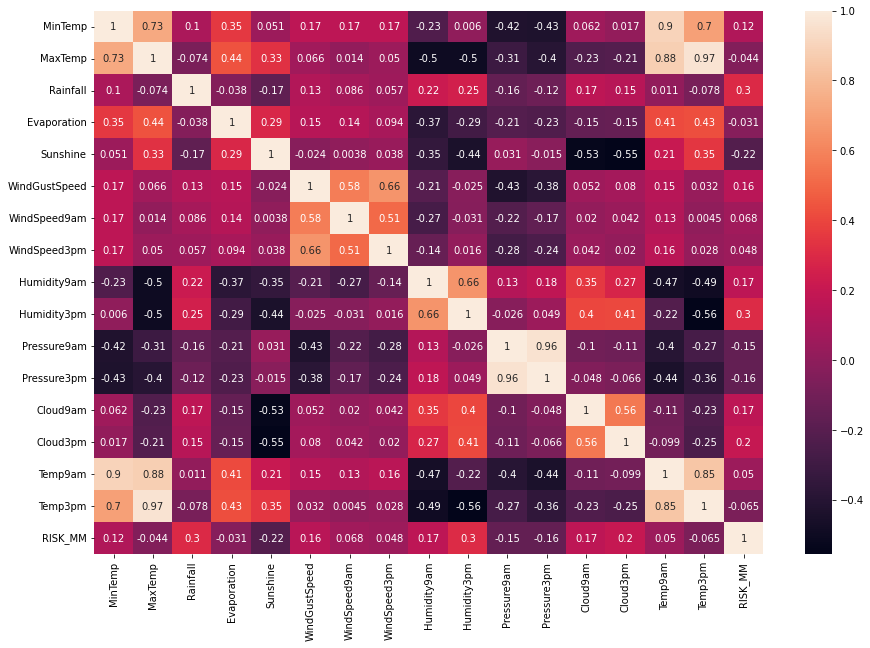

In [43]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(15,10))
sb.heatmap(data[data_num.columns].corr(), annot=True)

In [44]:
# Now lets split form and data into training and test sets. 
from sklearn.model_selection import train_test_split

X = data.drop(['RainTomorrow_Yes'], axis = 1)
y = data['RainTomorrow_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(f"The training sets have the following shapes: {X_train.shape, y_train.shape}")
print(f"The testing sets have the following shapes: {X_test.shape, y_test.shape}")

The training sets have the following shapes: ((116368, 114), (116368,))
The testing sets have the following shapes: ((29092, 114), (29092,))


In [45]:

from sklearn.preprocessing import MinMaxScaler

cols = list(X_train.columns)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=[cols])

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=[cols])

X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM,year,month,Day,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,...,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes
count,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,...,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000,116368.000000
mean,0.512182,0.529462,0.006459,0.037683,0.524383,0.263994,0.108049,0.225112,0.689300,0.515916,0.613968,0.610412,0.494599,0.563806,0.510190,0.519608,0.006400,0.576706,0.490463,0.491065,0.020925,0.020908,0.020882,0.020856,0.020616,0.021252,0.021561,0.021071,0.023649,0.020409,0.020770,0.020676,0.021853,0.020908,0.022300,0.010338,0.021011,0.022231,0.020684,0.020452,...,0.055557,0.062766,0.064769,0.063574,0.060352,0.062320,0.138397,0.056966,0.062216,0.053322,0.052102,0.153771,0.053296,0.055342,0.055213,0.059836,0.059776,0.064408,0.062440,0.052635,0.057988,0.058117,0.050564,0.048252,0.054285,0.058427,0.061340,0.057103,0.045339,0.054078,0.059123,0.068447,0.103723,0.065224,0.056055,0.064786,0.069323,0.060309,0.064958,0.219648
std,0.157596,0.133935,0.022980,0.021845,0.188436,0.101745,0.068154,0.105064,0.188109,0.204399,0.111210,0.106584,0.251684,0.261533,0.136067,0.131434,0.022740,0.253840,0.311405,0.293231,0.143134,0.143076,0.142990,0.142904,0.142094,0.144222,0.145245,0.143622,0.151954,0.141397,0.142615,0.142297,0.146204,0.143076,0.147658,0.101149,0.143421,0.147435,0.142326,0.141542,...,0.229064,0.242543,0.246118,0.243994,0.238138,0.241736,0.345318,0.231778,0.241549,0.224676,0.222234,0.360730,0.224625,0.228647,0.228396,0.237184,0.237072,0.245479,0.241954,0.223304,0.233723,0.233966,0.219106,0.214299,0.226580,0.234550,0.239954,0.232041,0.208047,0.226173,0.235855,0.252512,0.304902,0.246922,0.230029,0.246149,0.254004,0.238059,0.246452,0.414010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initiatlize the model
logreg = LogisticRegression(solver='liblinear', random_state = 0)

# Fit the model
logreg.fit(X_train, y_train)

# Predict data points 
y_pred_test = logreg.predict(X_test)

# Print accuracy scores
print(f'Model accuracy score: {round(accuracy_score(y_test, y_pred_test) * 100, 2)}%')

Model accuracy score: 90.31%


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     22726
           1       0.91      0.62      0.74      6366

    accuracy                           0.90     29092
   macro avg       0.90      0.80      0.84     29092
weighted avg       0.90      0.90      0.90     29092



0.994259590265365

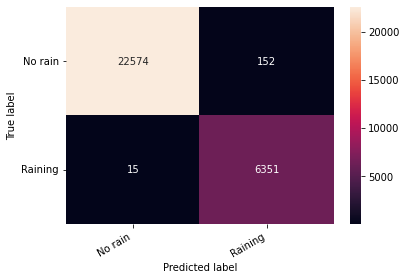

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
classes = ['No rain', 'Raining']
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sb.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

accuracy_score(y_test, y_pred)

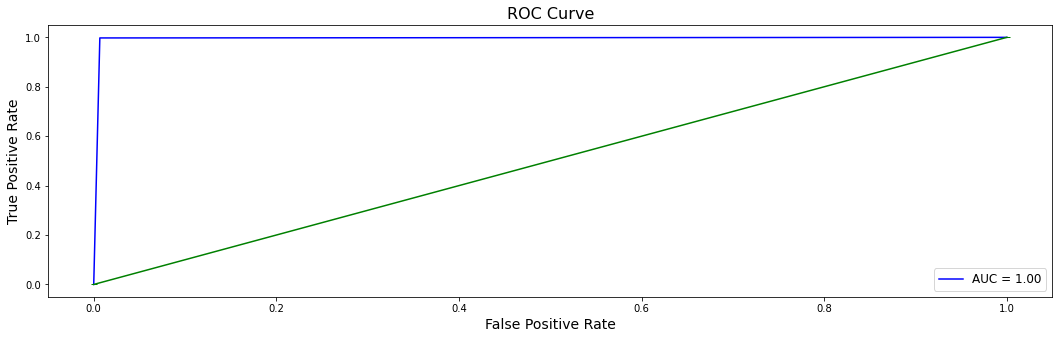

In [50]:
# Import auc, roc_curve
from sklearn.metrics import auc, roc_curve

# Get false positive rate, true positive rate and threshold
fpr, tpr, threshold = roc_curve(y_test, y_pred)

# Compute Area under curve
area = auc(fpr, tpr)

# plot the roc curve
# Initialize Figure
plt.figure(figsize=(18,5))

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % area)

# plot straight line
plt.plot([0, 1], [0, 1],color='g', marker='_')

# set plot title, xlabel, ylabel, legend
plt.title('ROC Curve', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.legend(loc = 'lower right', fontsize = 12)

plt.show()
# The confusion matrix, accuracy score and ROC suggest that the model performed well